Construction of Book Recommendation & Summarization Models

In [ ]:
!pip install torch torchvision torchaudio
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.0 MB/s eta 0:00:00


[link text](https:// [link text](https://))# Import and Load Summarizer Model

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import sentencepiece
import string

In [ ]:
#load tokenizer
tokenizer = PegasusTokenizer.from_pretrained("pszemraj/pegasus-x-large-book-summary")

In [ ]:
#load model
model = PegasusForConditionalGeneration.from_pretrained("pszemraj/pegasus-x-large-book-summary")

You are using a model of type pegasus_x to instantiate a model of type pegasus. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at pszemraj/pegasus-x-large-book-summary were not used when initializing PegasusForConditionalGeneration: ['model.encoder.layers.6.global_self_attn_layer_norm.bias', 'model.encoder.layers.10.global_self_attn_layer_norm.weight', 'model.encoder.layers.4.global_self_attn_layer_norm.bias', 'model.encoder.layers.5.global_self_attn_layer_norm.weight', 'model.encoder.layers.14.global_self_attn_layer_norm.bias', 'model.encoder.layers.8.global_self_attn_layer_norm.weight', 'model.encoder.layers.13.global_self_attn_layer_norm.bias', 'model.encoder.layers.11.global_self_attn_layer_norm.weight', 'model.encoder.layers.7.global_self_attn_layer_norm.weight', 'model.encoder.layers.15.global_self_attn_layer_norm.bias', 'model.encoder.layers.10.global_self_attn_layer_norm.bias', 'model.encoder.layers.3.global_self_attn_layer_norm.bias', 'model.encoder.layers.1.global_self_attn_layer_norm.weight', 'model.encoder.layers.8.global_self_attn_layer_norm.bias', 'model.encod

# Perform Abstract Summarization


In [ ]:
text = """
Bret Easton Ellis’s first novel, Less Than Zero, published in 1985, is hard to shake—a drifting, menacing story about Los Angeles private school kids with monosyllabic names (Clay, Blair, Trent, Rip) who go to parties, do drugs, have sex and try to feel something about any of it. The Shards, Ellis’s hypnotic, prodigious and unsettling new novel—his first in 13 years—is a time machine back to that early ’80s milieu. It stars none other than Ellis himself, a prep school senior writing a novel called Less Than Zero and surrounded by a pack of rich, beautiful friends who are themselves shadowed by a serial killer nicknamed the Trawler. Ellis holds nothing back through these 600 pages: baroque violence, startling eroticism, relentless cataloguing of mood-specific song and movie titles. His gothic predilections are not for everyone (the Trawler’s kills are grotesque) but the evocation of a certain kind of vacant privilege—a buried longing overlaid with studied dissociation—is masterful. –Taylor Antrim
"""

In [ ]:
#create token
tokens = tokenizer(text, truncation=True, padding="longest", return_tensors="pt")
tokens['input_ids'][0].shape

torch.Size([218])

In [ ]:
#summarize
summary = model.generate(**tokens)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
tokenizer.decode(summary[0])

'<pad>Bret Easton Ellis\'s first novel is hard to write, a story about Los Angles private school kids who go to party, do drugs and have sex. Ellis has published only one other novel in the last 13 years, The Shards. Ellis\' new novel is a time machine. It stars Ellis himself, surrounded by a group of rich, attractive friends who are shadowed by the Trawlers serial killer nicknamed Trawler, who Ellis calls the "Trawler." The narrator holds nothing back in this 600-page novel. Ellis holds everything back through these chapters: baroque violence. startling erosis. relentless cataloguing of moods-specific song, movie titles. Ellis gothic predilections aren\'t for everyone, but the evocations of a certain vacant privilege -- a buried longing overlaid by studied dissociation --is masterful. The narrator describes Ellis as "hypnotic, prodigious, and unsettling" and his first novel in 13 years. The novel stars none but Ellis himself. He is surrounded by friends and surrounded by rich, beautif

In [ ]:
#aggregating into a summarize function

def summarize(des):
  text = des
  tokens = tokenizer(text, truncation=True, padding="longest", return_tensors="pt")
  summary = model.generate(**tokens, max_new_tokens = 100)
  output = tokenizer.decode(summary[0], skip_special_tokens=True)
  #ensure summary doesn't end on unfinished sentence
  last_punc_index = max(output.rfind(p) for p in string.punctuation)
  output = output[:last_punc_index + 1]
  return output

# Getting book descriptions from Goodreads

In [ ]:
import requests

def search_book_description(title):
    # Google Books API endpoint for book search
    url = "https://www.googleapis.com/books/v1/volumes"

    # Parameters for the book search
    params = {
        "q": title,
        "maxResults": 1
    }

    # Send GET request to Google Books API
    response = requests.get(url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response to extract the book description
        data = response.json()

        if "items" in data and len(data["items"]) > 0:
            book_description = data["items"][0]["volumeInfo"].get("description", "No description available.")
            return book_description
        else:
            print("No book found with the given title.")
            return None
    else:
        # If the request failed, print the error message
        print("Error:", response.status_code, response.text)
        return None


In [ ]:
# Usage example
book_title = "1984"
description = search_book_description(book_title)
if description:
    print(description)

"Nineteen Eighty-Four: A Novel", often published as "1984", is a dystopian social science fiction novel by English novelist George Orwell. It was published on 8 June 1949 by Secker & Warburg as Orwell's ninth and final book completed in his lifetime. Thematically, "Nineteen Eighty-Four" centres on the consequences of totalitarianism, mass surveillance, and repressive regimentation of persons and behaviours within society. Orwell, himself a democratic socialist, modelled the authoritarian government in the novel after Stalinist Russia. More broadly, the novel examines the role of truth and facts within politics and the ways in which they are manipulated. The story takes place in an imagined future, the year 1984, when much of the world has fallen victim to perpetual war, omnipresent government surveillance, historical negationism, and propaganda. Great Britain, known as Airstrip One, has become a province of a totalitarian superstate named Oceania that is ruled by the Party who employ t

In [ ]:
summarize(description)

'Nineteen Eighty-Four is a dystopian novel by George Orwell, published in June 1949 as "1984". The novel takes place in the year 1984, in a fictional future in Great Britain, ruled by a Party that employs the Thought Police. The protagonist is named Smith and he is a diligent, skillful rank- and file worker who secretly hates and dreams of rebelling against the Party. He secretly hates the Outer Party member and fantasizes about rebellion.'

# Book Recommendation Model

**Download and load data**

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Move the uploaded file to Google Drive
!mv "/kaggle.json" "/content/drive/My Drive"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mv: cannot stat '/kaggle.json': No such file or directory


In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/My Drive"


In [ ]:
#downloading dataset
!kaggle datasets download -d ruchi798/bookcrossing-dataset

 85% 65.0M/76.1M [00:01<00:00, 43.2MB/s]
100% 76.1M/76.1M [00:01<00:00, 46.2MB/s]


In [ ]:
#unzip dataset
import zipfile

# Specify the path to the downloaded zip file
zip_file_path = "/content/bookcrossing-dataset.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall("/content")


**Load & Process data**

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from fastai.collab import *

In [ ]:
books = pd.read_csv('/content/Book reviews/Book reviews/BX_Books.csv',sep=";",error_bad_lines=False, encoding='latin-1')
ratings = pd.read_csv('/content/Book reviews/Book reviews/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1')
users = pd.read_csv('/content/Book reviews/Book reviews/BX-Users.csv', sep=';', error_bad_lines=False, encoding='latin-1')

<ipython-input-20-4dc3c50e4e8e>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('/content/Book reviews/Book reviews/BX_Books.csv',sep=";",error_bad_lines=False, encoding='latin-1')
<ipython-input-20-4dc3c50e4e8e>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ratings = pd.read_csv('/content/Book reviews/Book reviews/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1')
<ipython-input-20-4dc3c50e4e8e>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  users = pd.read_csv('/content/Book reviews/Book reviews/BX-Users.csv', sep=';', error_bad_lines=False, encoding='latin-1')


Construct the dataframe fitting with fastai's CollabDataLoaders, with the 1st column for the user, 2nd column for the item (books), and 3rd column for rating. The 4th column is added as names for the books.

In [ ]:
df = ratings.copy()
df = df.merge(books, on='ISBN').iloc[:,:4]
df = df.rename(columns={"User-ID":"user", "ISBN":"isbn", "Book-Rating": "rating", "Book-Title":"title" })
df

,user,isbn,rating,title
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel
...,...,...,...,...
1031170,276688,0517145553,0,Mostly Harmless
1031171,276688,1575660792,7,Gray Matter
1031172,276690,0590907301,0,Triplet Trouble and the Class Trip (Triplet Trouble)
1031173,276704,0679752714,0,A Desert of Pure Feeling (Vintage Contemporaries)


**Data Cleaning**

In [ ]:
#check for null values
df.isna().sum()

user      0
isbn      0
rating    0
title     0
dtype: int64

***Create Dataloaders & Learner***

In [ ]:
dls = CollabDataLoaders.from_df(df, item_name="title", bs=64)

In [ ]:
dls.show_batch()

,user,title,rating
0,129358,The Wedding,0
1,51992,The Honey Thief,7
2,138649,She Loves Me Not,10
3,67785,Sense and Sensibility (Wordsworth Classics),8
4,40553,The Best American Short Stories 2001,0
5,254201,Amazing Real-Life Coincidences,7
6,76352,Shell Game (Kathleen Mallory Novels (Paperback)),0
7,69971,Firefly,1
8,203240,Number the Stars (Yearling Newbery),0
9,120908,Firestarter,0


In [ ]:
learn = collab_learner(dls, use_nn=True, layers=[20,10], y_range=(0,10.5))

SuggestedLRs(valley=0.005248074419796467)

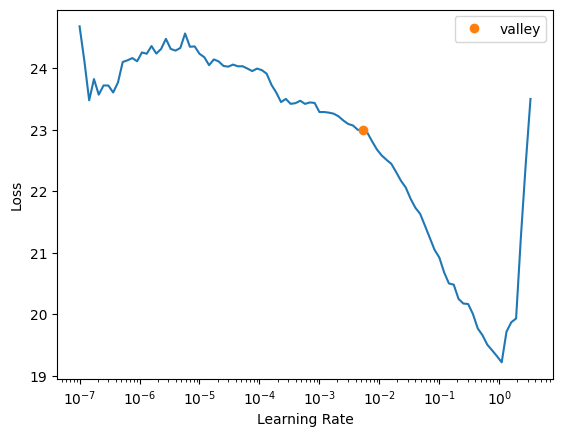

In [ ]:
#find learning rate
lr = learn.lr_find()
lr

In [ ]:
#fit the model
learn.fit_one_cycle(2,lr,wd=0.1)

epoch,train_loss,valid_loss,time


Export model and dataloader



In [ ]:
import pickle

# Open a file in write binary mode
with open('dataloader.pkl', 'wb') as f:
    # Use pickle.dump() to save the DataLoader object to the file
    pickle.dump(dls, f)

# Close the file
f.close()

In [ ]:
learn.save('myModel', with_opt=False)

Path('models/myModel.pth')